In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
from numpy.linalg import matrix_power
from numpy import linalg as la
from datetime import datetime as dt
from IPython.display import clear_output

### Parameters

In [2]:
SP_0 = 2
SP_t = 40/60 # 40 mins convert to hrs

farm_size = 10
growth_period = 150 #do not water last 15 days of the maturation
waterings = 1
pr_cleaning = 0.2
watering_interval = 3
tank_capacity = 1000
tank_max = tank_capacity
water_days = 135
water_onion_needs_per_day = (550/10)/(water_days) #cm
alpha_threshold = 0.5
h_const = rnd.uniform(0,0.06)
max_weight = 0
llambda = rnd.uniform(25.0-1.3,25.0+1.3) # max crop growth rate
ell = rnd.uniform(0.26-0.02, 0.26+0.02) # light extinction coefficient
rho = rnd.uniform(0.1387-0.0026, 0.1387+0.0026) # relative early growth rate for expolinear
w0 = rnd.uniform(4.47-0.15,4.47+0.15) # initial dry weight from Tei et al
wf = rnd.uniform(1266-58,1266+58) #final dry weight from Tei
r_logistic = rnd.uniform(0.1273-0.0011,0.1273+0.0011) #relative early growth rate for logistic
cleaning_costs = 0
default_pr_cleaning = 0.2
si_risk_from_pb = 0.0001 # a probability of surface infection for when salmonella failed to penetrate
small_eps = 0.00001
gamma_0 = rnd.uniform(3.35-1.50,3.35+1.50)
alpha_0 = 3

risk_above = 0.06
risk_below = 0.025
m = 0.85 # fraction of the total SA of an onion that is penetrable by salmonella

In [3]:
protruding_time = rnd.randint(90,135)

In [5]:
SP = 2*SP_0

#salmonella_growth_rate = salmonella_growth_rate_model(SP_0, SP, SP_t)
# log10 per day
# salmonella_growth_rate = np.log(salmonella_growth_rate_model(SP_0, SP, SP_t))/np.log(10)

# log2 per day
salmonella_growth_rate = np.log(salmonella_growth_rate_model(SP_0, SP, SP_t))/np.log(2)

In [6]:
will_clean = clean_my_tank(pr_cleaning)

### Helper Functions

In [4]:
# initialize the onion farm
def initialize_farm(n):
	global tank_capacity
	global tank_max
	
	tank_capacity = tank_max
	A = []
	onion = "o"
	for i in range(n):
		row = []
		for j in range(n):
			row.append(onion)
		A.append(row)
	return A

# pretty print the farm
# dd here is the dictionary of the onions
def print_farm(dd):
	size = int(np.sqrt(len(dd)))
	for k in range(1,len(dd)+1):
		icon = dd[k]['shape']
		loc_y = dd[k]['loc_y']
		print(icon, " ", end='')
		
		if ((loc_y+1) % size == 0):
			print()

# initialize dictionaries for the farm
def initialize_dictionaries(n):
	#waterings = 0
	dictionaries = dict()
	onion_id = 1
	for i in range(n):
		for j in range(n):
			onion_dictionary = dict()
			onion_dictionary['id'] = onion_id
			onion_dictionary['loc_x'] = i
			onion_dictionary['loc_y'] = j
			onion_dictionary['state'] = 1
			onion_dictionary['shape'] = 'o'
			psm = ps_model(0) 
			onion_dictionary['ps'] = ps_model(0)[0]     # change this when you are ready
			onion_dictionary['pb'] = pb_model(0)     # change this when you are ready
			alpha_value = -alpha_0 * np.log(1-onion_dictionary['ps'])
			onion_dictionary['P'] = main_tpm(onion_dictionary['ps'], onion_dictionary['pb'], alpha_value)
			onion_dictionary['v'] = np.array([[1,0,0]])
			onion_dictionary['phi'] = phi_model(0)
			onion_dictionary['P_prime'] = tpm_prime(onion_dictionary['phi'], alpha_value)
			onion_dictionary['alphas'] = []
			onion_dictionary['cleaning_timestamps'] = []
			
			dictionaries[onion_id] = onion_dictionary
			
			onion_id += 1
	return dictionaries

# update shape
def upd_shape(dd):
	shapes = {1: 'o', 2: 's', 3: 'x'}
	for k in range(1,len(dd)+1):
		dd[k]['shape'] = shapes[dd[k]['state']]
	return dd

# get the main transition probability matrix
def main_tpm(ps, pb, alpha):
	P = np.array([[1-ps, ps*(1-pb), ps*pb],
				 [1-ps+compute_recovery_rate(alpha), ps*(1-pb)-compute_recovery_rate(alpha), ps*pb],
				  [small_eps,0,1-small_eps]])
	return P

def tpm_prime(phi, alpha):
	eps_pr = eps_prime()
	gamma_pr = gamma_prime()
	P_prime = np.array([[1-gamma_pr-eps_pr,gamma_pr,eps_pr],
						[compute_recovery_rate(alpha),1-phi-compute_recovery_rate(alpha),phi],
						[small_eps,0,1-small_eps]])
	return P_prime

def gamma_prime():
	return rnd.uniform(0,0.02) 

def eps_prime():
	return rnd.uniform(0,0.0001)

# probability for a surface infected onion to become bodily infected
# during a non-watering step
def phi_model(t):
	return rnd.uniform(0,0.001)

# function for ps
def ps_model(t):
	global alpha_threshold, cleaning_costs
	# insert model here for ps given time t
	# Model 1: Uniform Random between [0,0.2]
	'''
		ps = rnd.uniform(0,0.2) 
	'''
	
	# Model 2: In Terms of Salmonella Concentration
	scm = salmonella_concentration_model(t)
	alpha = scm[0]
	ps = 1-np.exp(-alpha/alpha_0)
	
	return (ps, scm[1], scm[2])

# function for salmonella concentration alpha with respect to time
def salmonella_concentration_model(t):
	global salmonella_growth_rate, tank_capacity, cleaning_costs, alphas, cleaning_timestamps
	
	# assume these
	V_w = water_onion_needs_per_day # how much an onion needs per day
	V_0 = tank_capacity # max capacity of tank
	tank_capacity -= V_w # remove water from tank
	n_0 = SP_0 # assume initially two salmonella cells
	K = salmonella_growth_rate #global
	
	phi = V_w / V_0
	
	alpha_concentration = ( n_0 * (1-phi)**(t-1) * phi * np.exp(t*K) ) / V_w
	sc = -1
	time_stamp = -1
# 	if will_clean:
# 		sc = alpha_concentration
# 		alpha_concentration = init_salmonella_concentration()
# 		time_stamp = t
	if np.random.choice([1,0], p=[pr_cleaning,1-pr_cleaning]):
		sc = alpha_concentration
		alpha_concentration = init_salmonella_concentration()
		time_stamp = t
	return (alpha_concentration, sc, time_stamp)

def init_salmonella_concentration():
	return SP_0 / tank_max

# p_0 initial population, p_f final population, time interval
def salmonella_generation_time_model(p_0, p_f, t):
	div = p_f/p_0
	log = np.log(div)
	G = t/(3.3 * log)
	return G

# p_0 initial population, p_f final population, time interval
def salmonella_growth_rate_model(p_0, p_f, t):
	
	G = salmonella_generation_time_model(p_0, p_f, t)
	return 0.301/G

# given generation time
def growth_rate_model(gt):
	return 0.301/gt

# function for pb
# return a tuple where
# ... pb_model(t)[0] = pb
# ... pb_model(t)[1] = boolean that determines whether salmonella
#       stuck onto the onion when penetration fails (i.e. surface infection)
def pb_model(t):
	global m
	global risk_above
	global risk_below
	
	# insert model here for pb given time t
	# Model 1: Uniform Random [0,0.0001]
	'''
		pb = rnd.uniform(0,0.0001)
	'''
	
	# Model 2:
	A = surface_area_model(t)
	
	A_above = A[0]
	A_below = A[1]
	
	risk_total = 0
	si_aggregate = False
	for i in range(int(m*A_above)):
		r_above = np.random.choice([risk_above,0], p=[risk_above,1-risk_above])
# 		if r_above == 0:
# 			si = np.random.choice([1,0], p=[si_risk_from_pb,1-si_risk_from_pb])
# 			si_aggregate = si_aggregate or bool(si)
		risk_total += r_above
	for i in range(int(m*A_below)):
		r_below = np.random.choice([risk_below,0], p=[risk_below,1-risk_below])
# 		if r_below == 0:
# 			si = np.random.choice([1,0], p=[si_risk_from_pb,1-si_risk_from_pb])
# 			si_aggregate = si_aggregate or bool(si)
		risk_total += r_below
	
	pb = 0 if A[0] == 0 and A[1] == 0 else risk_total/(A_above + A_below)
	
	return pb
	return (pb, si_aggregate)

# surface_area given t
def surface_area_model(t):
	global h_const, protruding_time
	
	R = radius_model(t) # radius of an onion w.r.t time
	A = 4*np.pi*R*R
	
# 	h = max(h_const*(t-90),0)
	hc = 0.4
	h = max(hc*(t-protruding_time),0)
	
	A_above = 2*np.pi*R*h
	A_below = A-A_above
	return (A_above, A_below)

# get radius
def radius_model(t):
	w = weight_model(t)
	a = -3.8475  # these are from logarithmic regression coefficients
	b = 0.9937
# 	R = max(a + b*np.log(w),0)
# 	R = np.exp(R) if t > 90 else R

# 	special_R_expo = np.exp(2.0001-0.0002*w)
# 	special_R_quad = -0.00000004549121*w**2 - 0.00060944445769*w + 6.64923633446460
# 	special_R_expo = np.exp(-1.7286+0.0011*w)
# 	special_R_linear = 0.7255 + 0.0003*w
# 	special_R_expo = 3.027*np.exp(0.0001*w)
# 	special_R_expo = 0.1*np.exp(0.0012*w)
# 	special_R_expo = np.exp(-2.302705097+0.001200038*w)
	
# 	R = a + b*np.log(w) if t > 90 else special_R_expo
# 	R = 0.1 if t <= 60 else R
# 	if t <= 60:
# 		R = 0.1
# 	elif t > 60 and t < 90:
# 		R = special_R_expo
# 	elif t >= 90 and t <= 135:
# 		R = a + b*np.log(w)
# 	else:
# 		R = 2
	
# 	R = max(a + b*np.log(w),0.1)
	R = np.exp(0.9783 + 0.0015*w)
	scaling_factor = 0.7
	R = np.exp(0.2960 + 0.0050*w) * scaling_factor
	return R

# logistic from Tei et. al.
def weight_model(t):
	global water_days, llambda, ell, rho, wf, w0, r_logistic
	
	# leaf area index given time t (From Tei et. al. paper 1)
	L = 22.94*np.exp(-0.0214*t) if t > 90 else 0.0414*np.exp(0.0486*t)
# 	L =0.0414*np.exp(0.0486*t)

	time = min(t,water_days)
	ell_val = np.exp(ell) 
	rho_val = np.exp(rho)
	
	ell_val = ell
	rho_val = rho
	
	leaf_weight_percentage = 1.5774*0.9683**t
	bulb_percentage = 1-leaf_weight_percentage
	reduce_leaf_weight = 1 if t <= 90 else 11.1803*np.exp(-0.0268*t)
	max_weight = 0 if t <= 90 else llambda*91*np.log(ell_val*L + np.exp(-rho_val*91))
	w = 0.1 if t <= 60 else llambda*time*np.log(ell_val*L + np.exp(-rho_val*time))
	w = w if t <= 90 else -w + max_weight*2
# 	w = np.exp(w*reduce_leaf_weight) if t >= 90 else w
	
	w=max(llambda*time*np.log(ell_val*L + np.exp(-rho_val*time)),0.1)
	w=llambda*time*np.log(ell_val*L + np.exp(-rho_val*time))
# 	w = llambda**time * np.log( np.log(ell_val*L + np.exp(-rho_val*time)) )  
	horizontal_shift = 43
	scaling_factor = 0.38
	w = wf/( 1 + (wf/w0 - 1)*np.exp(-r_logistic*(time-horizontal_shift)) ) * scaling_factor
	return w 

# counts onions
def count_onions(dd):
	counter = {'o': 0, 's':0, 'x':0}
	for k in range(1,len(dd)+1):
		counter[dd[k]['shape']] += 1
	return counter

# gets average of list
def ave(ll):
	return sum(ll)/len(ll) if len(ll) != 0 else 0

# assuming non-empty list
def normalize_list(ll):
	if len(ll) == 0:
		return [0]
	else:
		return [item * (1/sum(ll)) for item in ll]

# assume len(ll) > 1
def min_max_norm(ll, new_min, new_max):
	old_range = max(ll) - min(ll)
	new_range = new_max - new_min
	return [(item-min(ll))/old_range*new_range + new_min for item in ll]

# assuming non-empty list
def cumulative_normalize_list(ll):
	if len(ll) == 0:
		return [0]
	else:
		normals = [item * (1/sum(ll)) for item in ll]
		base = 0
		cum_sum = []
		for item in normals:
			base += item
			cum_sum.append(base)
		return cum_sum
	
def compute_recovery_rate(alpha):
	return gamma_0*alpha/100

def clean_my_tank(pr_cleaning):
	global cleaning_costs
	clean_tank = np.random.choice([1,0], p=[pr_cleaning,1-pr_cleaning])
	if (clean_tank):
		cleaning_costs += 1
	return clean_tank

# simulator
def simulate(dd, days):
	global tank_capacity, water_days, alphas, will_clean
	
	for t in range(1,days+1):
		tank_capacity = tank_max
		will_clean = clean_my_tank(pr_cleaning)
		for k in range(1,len(dd)+1):
			P = dd[k]['P']
			
			# update ps and pb at time t
			psmt = ps_model(t)
			if t <= water_days:
				dd[k]['ps'] = psmt[0]
# 				pb_temp = pb_model(t)
				dd[k]['pb'] = pb_model(t)
				myalpha = -alpha_0 * np.log(1-dd[k]['ps'])
				dd[k]['P'] = main_tpm(dd[k]['ps'], dd[k]['pb'], myalpha)
			
			# compute the new probability state vector v
			dd[k]['v'] = np.dot(dd[k]['v'], P)
			dd[k]['v'] = np.dot(dd[k]['v'], dd[k]['P_prime'])
			
			# flip a biased coin that determines the state of the onion
			# note that the state will be absorbed at s3 if onion becomes bodily infected
			v = dd[k]['v']
			v = v.flatten()
			dd[k]['state'] = np.random.choice([1,2,3], p=v)
			if dd[k]['state'] == 2:
				alpha_value = -alpha_0 * np.log(1-dd[k]['ps'])
				dd[k]['alphas'].append(psmt[1])
				dd[k]['cleaning_timestamps'].append(psmt[2])
			else:
				dd[k]['alphas'].append(-1)
				dd[k]['cleaning_timestamps'].append(-1)
	dd = upd_shape(dd)
	return dd

In [17]:
cleaning_timestamps = [0]
alphas = [0]

In [8]:
for i in range(1,151):
	will_clean = clean_my_tank(pr_cleaning)
	sc = salmonella_concentration_model(i)

In [26]:
print(cleaning_timestamps)

[0, 5, 6, 8, 9, 10, 12, 14, 18, 20, 21, 22, 25, 26, 35, 41, 44, 49, 61, 66, 69, 71, 84, 85, 95, 100, 110, 115, 119, 120, 124, 125, 128, 129, 133, 135, 149]


In [34]:
print(alpha_list)

[0, 0.002874832926162467, 0.003011658796490407, 0.0033051547436447233, 0.003462459246168964, 0.0036272496562250655, 0.003980729965753851, 0.004368653556431564, 0.005261580605409413, 0.005774308195638129, 0.006049112766188503, 0.006336994117584353, 0.007285470250746669, 0.007632183823419396, 0.011597529346744207, 0.015328703985154154, 0.017622765274590044, 0.022234108638239644, 0.038839964991488604, 0.04900221270324271, 0.05633477193096028, 0.06182297621038539, 0.11312701285894448, 0.11850902832092912, 0.18862382598685457, 0.23796601031313228, 0.37874176801840015, 0.4778075864788174, 0.5754118801919281, 0.6027815879198897, 0.7259110711232477, 0.7604383062160349, 0.8741882654222602, 0.9157671564071103, 1.1028189853358314, 1.2102165820981416, 2.319324650238942]


In [33]:
alpha_list = []
for item in cleaning_timestamps:
	alpha_list.append(alphas[item])

In [29]:
cleaning_intervals = []
for i in range(len(cleaning_timestamps)-1):
	diff = cleaning_timestamps[i+1] - cleaning_timestamps[i]
	cleaning_intervals.append(diff)

In [30]:
print(cleaning_intervals)

[5, 1, 2, 1, 1, 2, 2, 4, 2, 1, 1, 3, 1, 9, 6, 3, 5, 12, 5, 3, 2, 13, 1, 10, 5, 10, 5, 4, 1, 4, 1, 3, 1, 4, 2, 14]


In [35]:
alpha_list = alpha_list[1:]
print(alpha_list)

[0.002874832926162467, 0.003011658796490407, 0.0033051547436447233, 0.003462459246168964, 0.0036272496562250655, 0.003980729965753851, 0.004368653556431564, 0.005261580605409413, 0.005774308195638129, 0.006049112766188503, 0.006336994117584353, 0.007285470250746669, 0.007632183823419396, 0.011597529346744207, 0.015328703985154154, 0.017622765274590044, 0.022234108638239644, 0.038839964991488604, 0.04900221270324271, 0.05633477193096028, 0.06182297621038539, 0.11312701285894448, 0.11850902832092912, 0.18862382598685457, 0.23796601031313228, 0.37874176801840015, 0.4778075864788174, 0.5754118801919281, 0.6027815879198897, 0.7259110711232477, 0.7604383062160349, 0.8741882654222602, 0.9157671564071103, 1.1028189853358314, 1.2102165820981416, 2.319324650238942]


In [38]:
tuples = []
for i in range(len(cleaning_intervals)):
	tup = (cleaning_intervals[i], alpha_list[i])
	tuples.append(tup)
tuples = sorted(tuples, key=lambda tup: tup[0])
print(tuples)

[(1, 0.003011658796490407), (1, 0.003462459246168964), (1, 0.0036272496562250655), (1, 0.006049112766188503), (1, 0.006336994117584353), (1, 0.007632183823419396), (1, 0.11850902832092912), (1, 0.6027815879198897), (1, 0.7604383062160349), (1, 0.9157671564071103), (2, 0.0033051547436447233), (2, 0.003980729965753851), (2, 0.004368653556431564), (2, 0.005774308195638129), (2, 0.06182297621038539), (2, 1.2102165820981416), (3, 0.007285470250746669), (3, 0.017622765274590044), (3, 0.05633477193096028), (3, 0.8741882654222602), (4, 0.005261580605409413), (4, 0.5754118801919281), (4, 0.7259110711232477), (4, 1.1028189853358314), (5, 0.002874832926162467), (5, 0.022234108638239644), (5, 0.04900221270324271), (5, 0.23796601031313228), (5, 0.4778075864788174), (6, 0.015328703985154154), (9, 0.011597529346744207), (10, 0.18862382598685457), (10, 0.37874176801840015), (12, 0.038839964991488604), (13, 0.11312701285894448), (14, 2.319324650238942)]


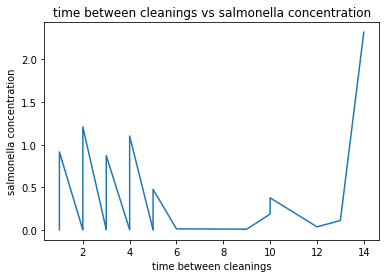

In [39]:
fig, ax = plt.subplots()
ax.plot([item[0] for item in tuples], [item[1] for item in tuples])

ax.set(xlabel='time between cleanings', ylabel='salmonella concentration',
       title='time between cleanings vs salmonella concentration')

plt.show()

In [56]:
runs = 100
cleaning_dict = dict()
for run in range(runs):
	cleaning_dict[run] = dict()
	cleaning_dict[run]['alphas'] = []
	cleaning_dict[run]['timestamps'] = []
	tank_capacity = tank_max
	for t in range(151):
		scm = salmonella_concentration_model(t)
		cleaning_dict[run]['alphas'].append(scm[1])
		cleaning_dict[run]['timestamps'].append(scm[2])

In [64]:
print(cleaning_dict[0]['timestamps'])

[1, 2, 4, 15, 16, 25, 27, 37, 42, 49, 52, 57, 61, 64, 65, 67, 72, 74, 77, 81, 84, 91, 95, 104, 111, 117, 124, 125, 129, 131, 134]


In [59]:
def return_nonnegative(ll):
	return [item for item in ll if item >= 0]

In [122]:
runs = 100
for run in range(runs):
	cleaning_dict[run]['alphas'] = return_nonnegative(cleaning_dict[run]['alphas'])
	cleaning_dict[run]['timestamps'] = return_nonnegative(cleaning_dict[run]['timestamps'])

In [123]:
for run in range(runs):
	cleaning_dict[run]['intervals'] = []
	cleaning_dict[run]['alphas'].pop(0)
	prev = cleaning_dict[run]['timestamps'][0]
	for item in cleaning_dict[run]['timestamps']:
		if item == prev:
			continue
		curr = item
		cleaning_dict[run]['intervals'].append(curr-prev)
		prev = curr

In [66]:
print(cleaning_dict[0]['alphas'])

[0.0021958069137069935, 0.002409800224732154, 0.0040188679383714515, 0.0042101373735381935, 0.0063977270172475235, 0.007021165371114238, 0.011176920098638604, 0.014101839070354923, 0.019525742546659564, 0.022447974634701336, 0.028322066077118756, 0.034110000266171836, 0.03921466235691215, 0.041080643618264474, 0.045083177372215205, 0.056879569397682905, 0.062421247842534486, 0.07176225131254146, 0.08642639278369352, 0.09935924252092514, 0.1375676864336815, 0.1656769593354821, 0.2517299877688283, 0.34852285709512243, 0.4606159949648858, 0.6377161389994159, 0.6680532967076329, 0.8045351768988612, 0.8828998966281109, 1.0149868993030284]


In [67]:
print(cleaning_dict[0]['timestamps'])

[1, 2, 4, 15, 16, 25, 27, 37, 42, 49, 52, 57, 61, 64, 65, 67, 72, 74, 77, 81, 84, 91, 95, 104, 111, 117, 124, 125, 129, 131, 134]


In [68]:
print(cleaning_dict[0]['intervals'])

[1, 2, 11, 1, 9, 2, 10, 5, 7, 3, 5, 4, 3, 1, 2, 5, 2, 3, 4, 3, 7, 4, 9, 7, 6, 7, 1, 4, 2, 3]


In [70]:
data_points = []
for run in range(runs):
	for t in range(len(cleaning_dict[run]['alphas'])):
		t1 = cleaning_dict[run]['intervals'][t]
		t2 = cleaning_dict[run]['alphas'][t]
		data_points.append((t1,t2))

In [72]:
data_points = sorted(data_points, key=lambda tup: tup[0])

In [ ]:
fig, ax = plt.subplots()
ax.plot([item[0] for item in tuples], [item[1] for item in tuples])

ax.set(xlabel='time between cleanings', ylabel='salmonella concentration',
       title='time between cleanings vs salmonella concentration')

plt.show()

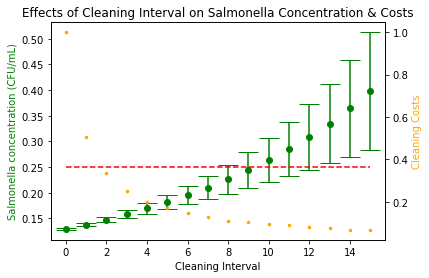

In [35]:
intervals = dict()
rt = 90
cd = []
for i in range(0,16):
	intervals[i] = []
	tank_capacity = tank_max
	while len(intervals[i]) < 100:
# 		rt = rnd.randint(1,135-i)
		pr_cleaning = 0
		for j in range(rt, rt+i):
			sm = salmonella_concentration_model(j)
		pr_cleaning = 1
		sm = salmonella_concentration_model(rt+i)
		intervals[i].append(sm[1])
	cd.append(np.ceil(135/(i+1)))
cd_max_scale = 1/max(cd)
cd = [item*cd_max_scale for item in cd]

pr_cleaning = 0.2

#actuals
ci = []
av = []

#errorbars
nci = []
mean_av = []
sd_av = []
for i in range(0,len(intervals)):
	my_list = intervals[i]
	nci.append(i)
	mean_val = np.mean(my_list)
	sd_val = np.std(my_list)
	mean_av.append(mean_val)
	sd_av.append(sd_val)
	for item in intervals[i]:
		ci.append(i)
		av.append(item)

# plt.errorbar(nci, mean_av, yerr=sd_av, capsize=10, fmt='o')
# plt.xlabel('cleaning interval (days)')
# plt.ylabel('salmonella concentration (CFU/mL)')
# plt.title('cleaning interval vs salmonella concentration')
# plt.xticks(np.arange(0,len(nci)+1,1))

# plt.plot(range(0,16), cd, '.', markersize=5)
# # plt.plot(ci, av, '.', markersize=5)
# plt.show()

fig, ax = plt.subplots()
ax.errorbar(nci, mean_av, yerr=sd_av, capsize=10, fmt='o', color='green')
# ax.plot(range(1,N+1), healthy_onions, color="green")
plt.plot(range(0,16), [0.25]*16, linestyle='dashed', color='red')

ax.set(xlabel='Cleaning Interval', ylabel='Salmonella Concentration (CFU/mL)',
       title='Effects of Cleaning Interval on Salmonella Concentration & Costs')
ax.set_ylabel("Salmonella concentration (CFU/mL)",color="green")
# plt.yticks(np.arange(0.7, 1.01, 0.1))

ax2=ax.twinx()
ax2.plot(nci, cd, '.', markersize=5, color="orange")
ax2.set_ylabel("Cleaning Costs",color="orange")
# plt.plot(range(0,16), [0.5]*16, linestyle='dashed', color='blue')
# plt.yticks(np.arange(0, 0.07, 0.01))

plt.show()

# Determine the Top Five Intervals:
# scv = mean_av
# topk = 5
# print("The Top " + str(topk) + " Recommended Cleaning Intervals")
# for i in range(topk):
# 	argmin = np.argmin(scv)
# 	mmin = min(scv)
# 	print(str(i+1) + ") " +  str(argmin) + " Days <=> Salmonella Concentration: " + str(mmin))
# 	scv[argmin] = np.inf

In [21]:
print(cd)

[135.0, 68.0, 45.0, 34.0, 27.0, 23.0, 20.0, 17.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 9.0]


In [7]:
intervals = dict()
for i in range(1,31):
	intervals[i] = []
	tank_capacity = tank_max
	while len(intervals[i]) < 100:
		r = rnd.randint(1,135)
		sm = salmonella_concentration_model(r)
		if sm[1] >= 0:
			intervals[i].append(sm[1])

In [149]:
print(np.mean(intervals[1]))

0.128721854251962


In [153]:
np.argmin(mean_av[1:])

14

In [8]:
#actuals
ci = []
av = []

#errorbars
nci = []
mean_av = []
sd_av = []
for i in range(1,len(intervals)+1):
	my_list = intervals[i]
	nci.append(i)
	mean_val = np.mean(my_list)
	sd_val = np.std(my_list)
	mean_av.append(mean_val)
	sd_av.append(sd_val)
	for item in intervals[i]:
		ci.append(i)
		av.append(item)

In [114]:
len(mean_av)

15

In [110]:
nsd_av = []
for item in sd_av:
	if item not in nci:
		nsd_av.append(item)

In [22]:
onion_fields[1]

{'id': 1,
 'loc_x': 0,
 'loc_y': 0,
 'state': 1,
 'shape': 'o',
 'ps': 0.0006664444938189185,
 'pb': 0.0,
 'P': array([[9.99333556e-01, 6.66444494e-04, 0.00000000e+00],
        [9.99371204e-01, 6.28796094e-04, 0.00000000e+00],
        [1.00000000e-05, 0.00000000e+00, 9.99990000e-01]]),
 'v': array([[1, 0, 0]]),
 'phi': 0.0008971627565077313,
 'P_prime': array([[9.81368965e-01, 1.86103869e-02, 2.06481903e-05],
        [3.76483997e-05, 9.99065189e-01, 8.97162757e-04],
        [1.00000000e-05, 0.00000000e+00, 9.99990000e-01]]),
 'alphas': [],
 'cleaning_timestamps': []}

In [42]:
print(onion_fields[5]['cleaning_timestamps'])

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


### Farm Simulator

In [35]:
onion_fields = initialize_dictionaries(farm_size)
print("Initial State of the Farm:")
print_farm(onion_fields)
print("Onion Counts:", count_onions(onion_fields))

Initial State of the Farm:
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
o  o  o  o  o  o  o  o  o  o  
Onion Counts: {'o': 100, 's': 0, 'x': 0}


In [36]:
t1 = dt.now()
print("Time started: ", t1)
onion_fields = initialize_dictionaries(farm_size)
onion_fields = simulate(onion_fields,growth_period)
clear_output()
print("The Farm after", growth_period, "days:")
print_farm(onion_fields)
print("Onion Counts:", count_onions(onion_fields))
t2 = dt.now()
print("Simulation time: ", str(t2-t1))

The Farm after 150 days:
o  o  o  s  o  s  s  o  o  o  
o  s  s  s  o  o  o  s  s  o  
o  o  o  o  o  o  o  o  s  o  
o  o  s  s  o  o  o  o  o  o  
o  s  o  o  o  o  s  s  o  o  
o  o  o  s  s  s  s  o  s  s  
o  s  s  o  o  o  o  o  x  o  
s  o  s  s  o  s  s  s  o  o  
o  s  o  s  o  o  o  s  o  o  
o  o  o  o  x  o  o  o  o  o  
Onion Counts: {'o': 67, 's': 31, 'x': 2}
Simulation time:  0:01:19.806171


In [29]:
onion_fields[1]['alphas']

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.15232550933897918,
 -1,
 -1,
 0.17491320888433468,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.6357538191235481,
 -1,
 0.6971436725314623,
 -1,
 0.001999999999999962,
 -1,
 0.001999999999999962,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

### 100 Simulations
We will run this simulation 100 times and see the percentage of healthy and percentage of surfacely-infected onions.

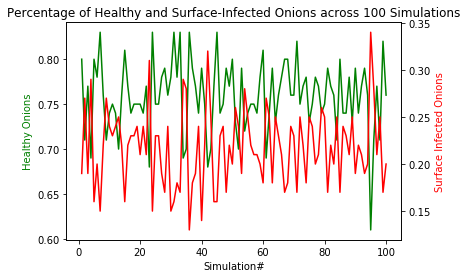

Simulation time:  2:33:31.543765


In [6]:
t1 = dt.now()
print("Time started: ", t1)
N = 100
healthy_onions = []
surface_infected_onions = []
for i in range(1,N+1):
	onion_fields = initialize_dictionaries(farm_size)
	onion_fields = simulate(onion_fields,growth_period)
	
	healthy_percentage = count_onions(onion_fields)['o']/100
	healthy_onions.append(healthy_percentage)
	
	surface_infected_percentage = count_onions(onion_fields)['s']/100
	surface_infected_onions.append(surface_infected_percentage)
	
	print("Done " + str(i))

clear_output()

fig, ax = plt.subplots()
ax.plot(range(1,N+1), healthy_onions, color="green")

ax.set(xlabel='Simulation#', ylabel='Healthy Onions',
       title='Percentage of Healthy and Surface-Infected Onions across 100 Simulations')
ax.set_ylabel("Healthy Onions",color="green")
# plt.yticks(np.arange(0.7, 1.01, 0.1))

ax2=ax.twinx()
ax2.plot(range(1,N+1), surface_infected_onions,color="red")
ax2.set_ylabel("Surface Infected Onions",color="red")
# plt.yticks(np.arange(0, 0.07, 0.01))
plt.show()

t2 = dt.now()
print("Simulation time: ", str(t2-t1))

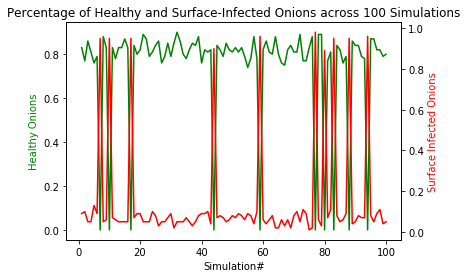

In [8]:
fig, ax = plt.subplots()
ax.plot(range(1,N+1), healthy_onions, color="green")

ax.set(xlabel='Simulation#', ylabel='Healthy Onions',
       title='Percentage of Healthy and Surface-Infected Onions across 100 Simulations')
ax.set_ylabel("Healthy Onions",color="green")
# plt.yticks(np.arange(0.7, 1.01, 0.1))

ax2=ax.twinx()
ax2.plot(range(1,N+1), surface_infected_onions,color="red")
ax2.set_ylabel("Surface Infected Onions",color="red")
# plt.yticks(np.arange(0, 0.07, 0.01))
plt.show()

This could be interpreted as most of the time, harvests give most to all healthy onions and only very few infected onions. This is fairy consistent. Although, there may be times when there's mostly infected ones and few healthy ones. And that's those times where the outbreaks linked to Salmonella happen. On average, based on this plot should be about 10/100=10% of the time.

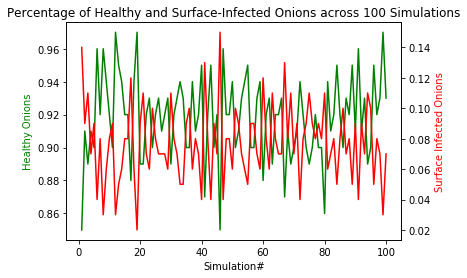

Simulation time:  1:55:08.196107


In [8]:
t1 = dt.now()
print("Time started: ", t1)
N = 100
healthy_onions = []
surface_infected_onions = []
for i in range(1,N+1):
	onion_fields = initialize_dictionaries(farm_size)
	onion_fields = simulate(onion_fields,growth_period)
	
	healthy_percentage = count_onions(onion_fields)['o']/100
	healthy_onions.append(healthy_percentage)
	
	surface_infected_percentage = count_onions(onion_fields)['s']/100
	surface_infected_onions.append(surface_infected_percentage)

clear_output()

fig, ax = plt.subplots()
ax.plot(range(1,N+1), healthy_onions, color="green")

ax.set(xlabel='Simulation#', ylabel='Healthy Onions',
       title='Percentage of Healthy and Surface-Infected Onions across 100 Simulations')
ax.set_ylabel("Healthy Onions",color="green")
# plt.yticks(np.arange(0.7, 1.01, 0.1))

ax2=ax.twinx()
ax2.plot(range(1,N+1), surface_infected_onions,color="red")
ax2.set_ylabel("Surface Infected Onions",color="red")
# plt.yticks(np.arange(0, 0.07, 0.01))
plt.show()

t2 = dt.now()
print("Simulation time: ", str(t2-t1))

In [9]:
healthy_onions

[0.85,
 0.91,
 0.89,
 0.91,
 0.9,
 0.96,
 0.92,
 0.96,
 0.94,
 0.92,
 0.9,
 0.97,
 0.95,
 0.94,
 0.92,
 0.92,
 0.88,
 0.94,
 0.97,
 0.89,
 0.89,
 0.92,
 0.93,
 0.9,
 0.92,
 0.93,
 0.91,
 0.92,
 0.93,
 0.89,
 0.92,
 0.93,
 0.94,
 0.93,
 0.9,
 0.9,
 0.94,
 0.91,
 0.92,
 0.95,
 0.87,
 0.92,
 0.95,
 0.9,
 0.92,
 0.85,
 0.96,
 0.92,
 0.92,
 0.94,
 0.9,
 0.91,
 0.93,
 0.94,
 0.95,
 0.9,
 0.9,
 0.93,
 0.94,
 0.88,
 0.92,
 0.93,
 0.89,
 0.92,
 0.92,
 0.93,
 0.87,
 0.91,
 0.89,
 0.9,
 0.91,
 0.94,
 0.92,
 0.9,
 0.89,
 0.9,
 0.92,
 0.9,
 0.9,
 0.86,
 0.94,
 0.91,
 0.92,
 0.95,
 0.92,
 0.9,
 0.93,
 0.92,
 0.95,
 0.91,
 0.96,
 0.91,
 0.93,
 0.89,
 0.9,
 0.95,
 0.92,
 0.93,
 0.97,
 0.93]

In [10]:
surface_infected_onions

[0.14,
 0.09,
 0.11,
 0.07,
 0.09,
 0.04,
 0.08,
 0.03,
 0.06,
 0.08,
 0.09,
 0.03,
 0.05,
 0.06,
 0.08,
 0.08,
 0.12,
 0.06,
 0.02,
 0.09,
 0.11,
 0.07,
 0.06,
 0.1,
 0.08,
 0.07,
 0.07,
 0.07,
 0.06,
 0.11,
 0.08,
 0.07,
 0.05,
 0.05,
 0.09,
 0.1,
 0.06,
 0.08,
 0.07,
 0.04,
 0.13,
 0.08,
 0.04,
 0.09,
 0.07,
 0.15,
 0.04,
 0.08,
 0.08,
 0.06,
 0.1,
 0.09,
 0.07,
 0.06,
 0.05,
 0.09,
 0.09,
 0.07,
 0.06,
 0.12,
 0.08,
 0.06,
 0.11,
 0.08,
 0.07,
 0.07,
 0.13,
 0.08,
 0.11,
 0.07,
 0.09,
 0.04,
 0.08,
 0.09,
 0.11,
 0.09,
 0.08,
 0.09,
 0.08,
 0.11,
 0.06,
 0.07,
 0.08,
 0.05,
 0.08,
 0.1,
 0.07,
 0.08,
 0.05,
 0.09,
 0.04,
 0.09,
 0.07,
 0.11,
 0.1,
 0.05,
 0.08,
 0.07,
 0.03,
 0.07]

In [6]:
# print(min(healthy_onions))
# print(max(healthy_onions))
# print(min(surface_infected_onions))
# print(max(surface_infected_onions))

0.07740000000000001
0.0005992400000000001


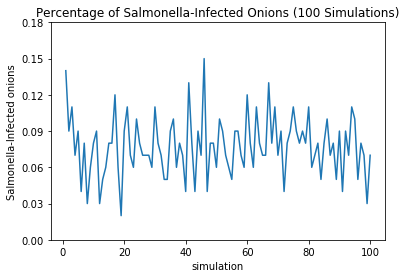

In [40]:

# plt.figure(figsize=(1,5))

fig, ax = plt.subplots()

ax.plot(range(1,101), surface_infected_onions)

ax.set(xlabel='simulation', ylabel='Salmonella-Infected onions',
       title='Percentage of Salmonella-Infected Onions (100 Simulations)')
plt.yticks(np.arange(0,0.2,0.03))

print(np.mean(surface_infected_onions))
print(np.std(surface_infected_onions)**2)

plt.show()

# x = range(1,101)
# y = healthy_onions

# plt.figure(figsize=(5,1))
# plt.plot(x,y)
# plt.show()

### Ps Analysis
We plot a time vs ps plot, to see how ps is changing overtime.

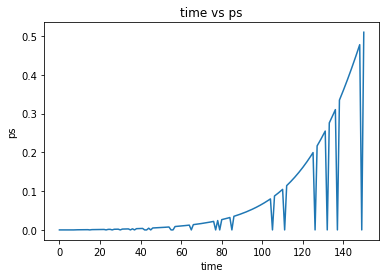

In [12]:
tank_capacity = tank_max
cleaning_costs
pss = []
for i in range(growth_period+1):
	pss.append(ps_model(i))

fig, ax = plt.subplots()
ax.plot(range(0,growth_period+1), pss)

ax.set(xlabel='time', ylabel='ps',
       title='time vs ps')

plt.show()

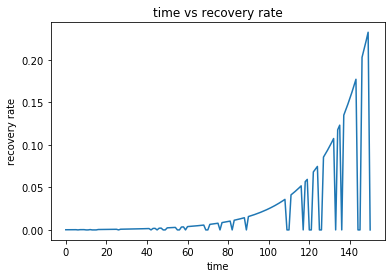

In [45]:
myalphas = []
for i in range(0,151):
	rr = gamma_0 * salmonella_concentration_model(i) / 100
	myalphas.append(rr)
fig, ax = plt.subplots()
ax.plot(range(0,growth_period+1), myalphas)

ax.set(xlabel='time', ylabel='recovery rate',
       title='time vs recovery rate')

plt.show()

### Probability of Cleaning
Each day, it was recommended to check the tank and clean every 1-2 days. Since there is no definitive suggestion on this interval, we set a probabilistic framework to see the best probabilistic cleaning scheme. Each day, we flip a coin as to whether or not we will coin, according to the following probabilities: 1%, 5%, 10% and 20%

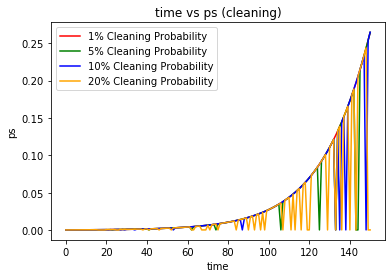

In [53]:
one_percent_cleaning = []
five_percent_cleaning = []
ten_percent_cleaning = []
twenty_percent_cleaning = []

for i in range(growth_period+1):
	pr_cleaning = 0.01
	one_percent_cleaning.append(ps_model(i))
	
	pr_cleaning = 0.05
	five_percent_cleaning.append(ps_model(i))
	
	pr_cleaning = 0.1
	ten_percent_cleaning.append(ps_model(i))
	
	pr_cleaning = 0.2
	twenty_percent_cleaning.append(ps_model(i))

fig, ax = plt.subplots()
ax.plot(range(0,growth_period+1), one_percent_cleaning, color='red', label='1% Cleaning Probability')
ax.plot(range(0,growth_period+1), five_percent_cleaning, color='green', label='5% Cleaning Probability')
ax.plot(range(0,growth_period+1), ten_percent_cleaning, color='blue', label='10% Cleaning Probability')
ax.plot(range(0,growth_period+1), twenty_percent_cleaning, color='orange', label='20% Cleaning Probability')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel='time', ylabel='ps',
       title='time vs ps (cleaning)')

plt.show()

It can be seen from the plot that ps is reduced given that we have a higher probabiity percentage. We can see it for ourselves when we consider the average as seen below

In [51]:
print("Average ps for 1% cleaning probability:",ave(one_percent_cleaning))
print("Average ps for 5% cleaning probability:",ave(five_percent_cleaning))
print("Average ps for 10% cleaning probability:",ave(ten_percent_cleaning))
print("Average ps for 20% cleaning probability:",ave(twenty_percent_cleaning))

Average ps for 1% cleaning probability: 0.04006731930924283
Average ps for 5% cleaning probability: 0.035676093257818633
Average ps for 10% cleaning probability: 0.035563382543358384
Average ps for 20% cleaning probability: 0.028611643196273205


It can be noted however that as we increase our probability of cleaning the tank, then we are reducing the possibility or probability of surface infection - on average. But however, this also means an increase in the cleaning costs. Note here that one dollar has been set per cleaning, as an assumption (this can easily be scaled if necessary).

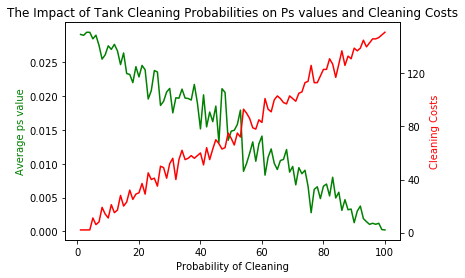

In [87]:
average_ps = []
costs = []
for c in range(1,101):
	pr_cleaning = c/100
	ps_vals = [ps_model(i) for i in range(growth_period+1)]
	average_ps.append(ave(ps_vals))
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	cleaning_costs = 0
	
pr_cleaning = default_pr_cleaning
	
fig, ax = plt.subplots()
ax.plot(range(1,101), average_ps, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='Average ps value',
       title='The Impact of Tank Cleaning Probabilities on Ps values and Cleaning Costs')
ax.set_ylabel("Average ps value",color="green")
plt.yticks(np.arange(0, 0.03, 0.005))

ax2=ax.twinx()
ax2.plot(range(1,101), costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
plt.yticks(np.arange(0, 160, 40))
plt.show()

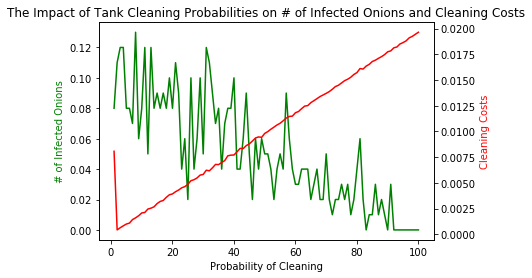

In [13]:
infected_count = []
costs = []
t1=dt.now()
for c in range(1,101):
	pr_cleaning = c/100
	fields = initialize_dictionaries(farm_size)
	fields = simulate(fields,growth_period)
	
	healthy_count = count_onions(fields)['o']
	infections = 100 - healthy_count
	infected_count.append(infections/100)
	
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	cleaning_costs = 0
	
	if c == 1:
		print('Done1')
		t2=dt.now()
		print(str(t2-t1))
	
clear_output()
pr_cleaning = default_pr_cleaning
normalized_cleaning_costs = cumulative_normalize_list(costs)
	
fig, ax = plt.subplots()
ax.plot(range(1,101), infected_count, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")
# plt.yticks(np.arange(0, 0.03, 0.005))

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
# plt.yticks(np.arange(0, 160, 40))
plt.show()

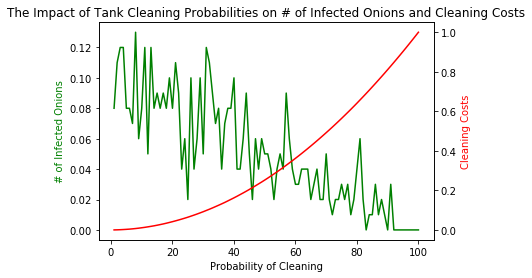

In [26]:
fig, ax = plt.subplots()
ax.plot(range(1,101), infected_count, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")
# plt.yticks(np.arange(0, 0.03, 0.005))

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
# plt.yticks(np.arange(0, 160, 40))
plt.show()

In [14]:
infected_count

[0.08,
 0.11,
 0.12,
 0.12,
 0.08,
 0.08,
 0.07,
 0.13,
 0.06,
 0.08,
 0.12,
 0.05,
 0.12,
 0.08,
 0.09,
 0.08,
 0.09,
 0.08,
 0.1,
 0.08,
 0.11,
 0.09,
 0.04,
 0.06,
 0.02,
 0.1,
 0.04,
 0.06,
 0.1,
 0.05,
 0.12,
 0.11,
 0.09,
 0.07,
 0.08,
 0.04,
 0.07,
 0.08,
 0.08,
 0.1,
 0.04,
 0.04,
 0.06,
 0.09,
 0.05,
 0.02,
 0.06,
 0.04,
 0.06,
 0.05,
 0.05,
 0.04,
 0.02,
 0.04,
 0.05,
 0.04,
 0.09,
 0.06,
 0.04,
 0.03,
 0.03,
 0.04,
 0.04,
 0.04,
 0.02,
 0.03,
 0.04,
 0.02,
 0.02,
 0.05,
 0.02,
 0.01,
 0.02,
 0.02,
 0.03,
 0.02,
 0.03,
 0.01,
 0.02,
 0.04,
 0.06,
 0.02,
 0.0,
 0.01,
 0.01,
 0.03,
 0.01,
 0.02,
 0.01,
 0.0,
 0.03,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [24]:
normalized_cleaning_costs = cumulative_normalize_list(costs)

In [19]:
costs

[0,
 290,
 437,
 565,
 685,
 749,
 986,
 1103,
 1245,
 1432,
 1466,
 1695,
 1754,
 1846,
 2063,
 2207,
 2275,
 2484,
 2656,
 2714,
 2863,
 2975,
 3125,
 3203,
 3355,
 3604,
 3670,
 3791,
 3983,
 4026,
 4310,
 4268,
 4470,
 4699,
 4688,
 4829,
 4956,
 5280,
 5324,
 5335,
 5550,
 5781,
 5763,
 5966,
 6084,
 6274,
 6480,
 6551,
 6525,
 6788,
 6909,
 7069,
 7210,
 7356,
 7470,
 7636,
 7818,
 7932,
 7951,
 8180,
 8262,
 8454,
 8627,
 8659,
 8858,
 8992,
 9129,
 9270,
 9377,
 9485,
 9604,
 9762,
 9942,
 10031,
 10187,
 10339,
 10439,
 10570,
 10757,
 10881,
 11156,
 11120,
 11320,
 11439,
 11629,
 11720,
 11844,
 11957,
 12095,
 12283,
 12345,
 12551,
 12607,
 12810,
 12902,
 13022,
 13222,
 13323,
 13462,
 13600]

In [25]:
normalized_cleaning_costs

[0.0,
 0.0004222905329743378,
 0.0010586386809391158,
 0.0018813771331132568,
 0.0028788564954836757,
 0.003969531009958776,
 0.005405318822071525,
 0.007011479021625644,
 0.008824415964912026,
 0.010909657493254274,
 0.013044408946152133,
 0.015512624302674555,
 0.018066753940043482,
 0.02075485160856289,
 0.02375893908968723,
 0.026972715663047105,
 0.030285512085518204,
 0.03390264892658115,
 0.037770247738925435,
 0.041722304657864584,
 0.045891331540297446,
 0.0502234499389135,
 0.054773994475274895,
 0.05943812060326387,
 0.06432358521750148,
 0.06957163722039635,
 0.07491579672389917,
 0.0804361533118499,
 0.08623609535611469,
 0.09209865289319981,
 0.09837476391774945,
 0.1045897156237304,
 0.11109881452854174,
 0.11794137733697765,
 0.12476792222864556,
 0.1317997876897941,
 0.13901658728090038,
 0.1467051873295366,
 0.15445785904524478,
 0.16222654867772096,
 0.1703083157742988,
 0.1787264591230045,
 0.18711839133518074,
 0.19580592692043902,
 0.20466529106739031,
 0.21380132

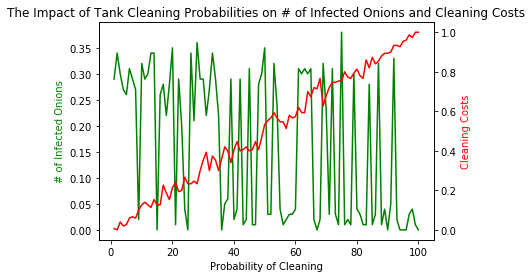

In [9]:
infected_count = []
costs = []
t1=dt.now()
for c in range(1,101):
	pr_cleaning = c/100
	cleaning_costs = 0
	fields = initialize_dictionaries(farm_size)
	fields = simulate(fields,growth_period)
	
	healthy_count = count_onions(fields)['o']
	infections = 100 - healthy_count
	infected_count.append(infections/100)
	
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	
	t2=dt.now()
	print('Done ' + str(c) + ": " + str(t2-t1))
	
clear_output()
pr_cleaning = default_pr_cleaning
normalized_cleaning_costs = min_max_norm(costs,0,1)
	
fig, ax = plt.subplots()
ax.plot(range(1,101), infected_count, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
plt.show()

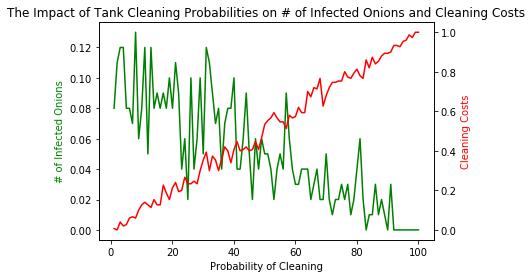

In [11]:
fig, ax = plt.subplots()
ax.plot(range(1,101), infections, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
plt.show()

In [6]:
all_my_costs = []
for c in range(0,101):
	pr_cleaning = c/100
	cost_list = []
	for t in range(0,151):
		clean_tank = np.random.choice([1,0], p=[pr_cleaning,1-pr_cleaning])
		cost_list.append(clean_tank)
	all_my_costs.append(cost_list)

In [12]:
print(all_my_costs[59])

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]


In [13]:
total_my_costs = []
for my_list in all_my_costs:
	total_my_costs.append(sum(my_list))

In [14]:
print(total_my_costs)

[0, 1, 2, 7, 6, 5, 7, 12, 13, 15, 16, 16, 17, 19, 16, 19, 24, 24, 33, 24, 30, 30, 50, 36, 37, 44, 36, 52, 45, 36, 56, 50, 50, 43, 52, 49, 57, 45, 61, 61, 66, 60, 68, 69, 70, 74, 68, 77, 74, 82, 70, 79, 80, 78, 79, 79, 83, 85, 84, 94, 93, 103, 82, 93, 81, 94, 102, 106, 110, 107, 112, 116, 102, 107, 100, 107, 107, 121, 111, 119, 112, 125, 113, 129, 124, 132, 131, 132, 132, 132, 141, 135, 145, 140, 146, 139, 146, 148, 147, 151, 151]


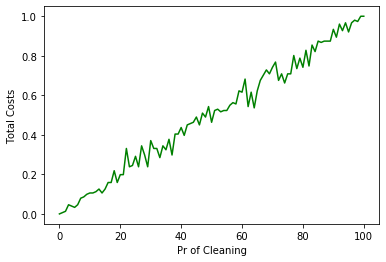

In [28]:
fig, ax = plt.subplots()
ax.plot(range(0,101), min_max_norm_costs, color="green")
ax.set_xlabel('Pr of Cleaning')
ax.set_ylabel('Total Costs')
plt.show()

In [ ]:
for c in range(1,101):
	pr_cleaning = c/100
	fields = initialize_dictionaries(farm_size)
	fields = simulate(fields,growth_period)
	
	healthy_count = count_onions(fields)['o']
	infections = 100 - healthy_count
	infected_count.append(infections/100)
	
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	cleaning_costs = 0
	
	if c == 1:
		print('Done1')
		t2=dt.now()
		print(str(t2-t1))
	
clear_output()
pr_cleaning = default_pr_cleaning
normalized_cleaning_costs = cumulative_normalize_list(costs)

In [27]:
min_max_norm_costs = min_max_norm(total_my_costs,0,1)

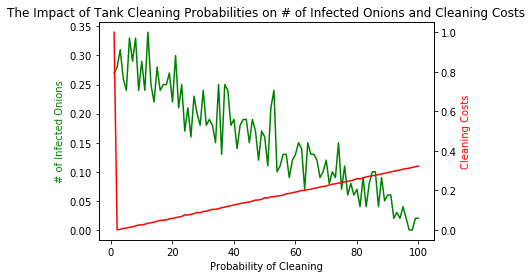

In [37]:
infected_count = []
costs = []
t1=dt.now()
for c in range(0,101):
	pr_cleaning = c/100
	cleaning_costs = 0
	fields = initialize_dictionaries(farm_size)
	fields = simulate(fields,growth_period)
	
	healthy_count = count_onions(fields)['o']
	infections = 100 - healthy_count
	infected_count.append(infections/100)
	
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	
	
	t2=dt.now()
	print('Done 1: ' + str(t2-t1))
	
clear_output()
pr_cleaning = default_pr_cleaning
normalized_cleaning_costs = min_max_norm(costs,0,1)
	
fig, ax = plt.subplots()
ax.plot(range(1,101), infected_count, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
plt.show()

In [40]:
print(costs)

[0, 280, 412, 573, 683, 815, 909, 1141, 1305, 1321, 1454, 1683, 1764, 1932, 2087, 2281, 2293, 2386, 2574, 2677, 2853, 2970, 3090, 3433, 3371, 3546, 3669, 3924, 3870, 4104, 4188, 4395, 4574, 4570, 4707, 4923, 5042, 5217, 5336, 5511, 5634, 5770, 5904, 6002, 6097, 6288, 6505, 6529, 6649, 6992, 6938, 7205, 7210, 7383, 7392, 7545, 7822, 7881, 8037, 8174, 8329, 8503, 8531, 8704, 8759, 8968, 9070, 9250, 9328, 9424, 9675, 9809, 9912, 10047, 10151, 10298, 10420, 10542, 10732, 10983, 10953, 11119, 11350, 11472, 11582, 11694, 11845, 11966, 12081, 12259, 12376, 12535, 12637, 12794, 12961, 13082, 13161, 13327, 13472, 13600]


In [43]:
print(infected_count)

[0.27, 0.28, 0.31, 0.26, 0.24, 0.33, 0.29, 0.33, 0.24, 0.29, 0.24, 0.34, 0.25, 0.22, 0.28, 0.24, 0.25, 0.25, 0.27, 0.22, 0.3, 0.21, 0.25, 0.17, 0.21, 0.16, 0.23, 0.2, 0.18, 0.24, 0.18, 0.19, 0.18, 0.15, 0.25, 0.13, 0.25, 0.24, 0.18, 0.19, 0.14, 0.18, 0.19, 0.19, 0.15, 0.19, 0.17, 0.12, 0.17, 0.16, 0.11, 0.21, 0.24, 0.1, 0.11, 0.13, 0.13, 0.09, 0.12, 0.13, 0.15, 0.14, 0.07, 0.15, 0.13, 0.13, 0.12, 0.09, 0.1, 0.12, 0.08, 0.1, 0.09, 0.15, 0.07, 0.11, 0.06, 0.08, 0.06, 0.07, 0.04, 0.09, 0.04, 0.08, 0.1, 0.1, 0.04, 0.09, 0.05, 0.06, 0.06, 0.02, 0.03, 0.02, 0.04, 0.02, 0.0, 0.0, 0.02, 0.02]


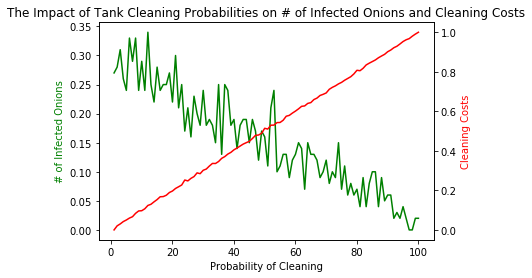

In [42]:
fig, ax = plt.subplots()
ax.plot(range(1,101), infected_count, color="green")

ax.set(xlabel='Probability of Cleaning', ylabel='# of Infected Onions',
       title='The Impact of Tank Cleaning Probabilities on # of Infected Onions and Cleaning Costs')
ax.set_ylabel("# of Infected Onions",color="green")

ax2=ax.twinx()
ax2.plot(range(1,101), normalized_cleaning_costs, color="red")
ax2.set_ylabel("Cleaning Costs",color="red")
plt.show()

In [66]:
infected_count = []
costs = []
t1=dt.now()
for c in range(0,101):
	pr_cleaning = c/100
	cleaning_costs = 0
	fields = initialize_dictionaries(farm_size)
	fields = simulate(fields,growth_period)
	
	healthy_count = count_onions(fields)['o']
	infections = 100 - healthy_count
	infected_count.append(infections/100)
	
	costs.append(cleaning_costs)
	tank_capacity = tank_max
	
	
	t2=dt.now()
	print('Done 1: ' + str(t2-t1))
	if c == 1:
		break

Done 1: 0:01:13.512373
Done 1: 0:02:25.948450


In [67]:
print(costs)

[0, 0]


### Leaf Area Index Analysis
This is important in calculating the plant weight of the onion (if we had used an Expolinear Model). A regression analysis can be found in the Excel file.

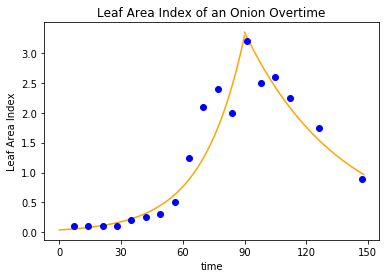

In [31]:
fig, ax = plt.subplots()
t = np.arange(0,89.99,0.01)
func = 0.0414*np.exp(0.0486*t)
ax.plot(t, func, color="orange")

t2 = np.arange(89.99,148,0.01)
func2 = 22.94*np.exp(-0.0214*t2)
ax.plot(t2, func2, color="orange")

time = list(np.arange(7,113,7)) + [126,147]
lai = [0.1,0.1,0.1,0.1,0.2,0.25,0.3,0.5,1.25,2.1,2.4,2,3.2,2.5,2.6,2.25,1.75,0.9]
plt.plot(time,lai,'o',color="blue")

ax.set(xlabel='time', ylabel='Leaf Area Index',
       title='Leaf Area Index of an Onion Overtime')

plt.xticks(np.arange(0, 155, 30))
plt.yticks(np.arange(0, 3.5, 0.5))
plt.show()

### Radius and Weight of Onion Overtime
It may be of interest to us how the onions' weight and radius changes overtime. Note here that radius is a function of weight and weight is a function of time. 

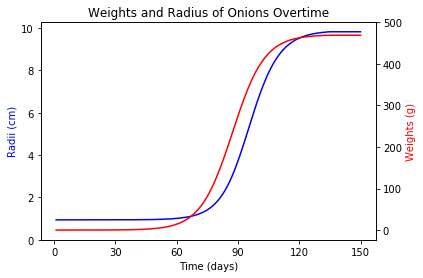

In [50]:
rads = []
weights = []
for i in range(1,growth_period+1):
	w = weight_model(i)
	R = np.exp(0.2960 + 0.0050*w) *0.7
	rads.append(R)
	weights.append(w)

fig, ax = plt.subplots()
ax.plot(range(1,growth_period+1), rads, color="blue")

ax.set(xlabel='Time (days)', ylabel='Weights',
       title='Weights and Radius of Onions Overtime')
ax.set_ylabel("Radii (cm)",color="blue")
plt.xticks(np.arange(0, 151, 30))
plt.yticks(np.arange(0,11,2))

ax2=ax.twinx()
ax2.plot(range(1,growth_period+1), weights,color="red")
ax2.set_ylabel("Weights (g)",color="red")
plt.yticks(np.arange(0, 501, 100))
plt.show()

In [7]:
rads = []
weights = []
for i in range(1,growth_period+1):
	w = weight_model(i)
	R = np.exp(0.2960 + 0.0050*w) *0.7
	rads.append(R)
	weights.append(w)

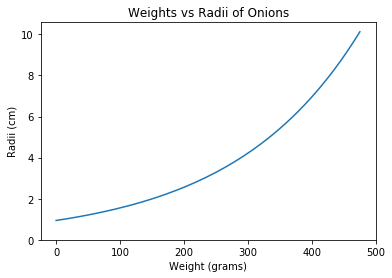

In [14]:
fig, ax = plt.subplots()
ax.plot(weights, rads)
ax.set_title('Weights vs Radii of Onions')
ax.set_xlabel('Weight (grams)')
ax.set_ylabel('Radii (cm)')
plt.yticks(np.arange(0, 11, 2))
plt.xticks(np.arange(0, 501, 100))
plt.show()

### Surface Area of the Onions Overtime
Notice that the bulb only begins to form at time t=60 to 90, and then it begins to mature at a much faster rate. Then at sometime at t=90 to 120, it hits its inflection point where the maturity rate starts to decline. At some time point around 120, the onion bulb begins to rise from the ground leading to the decrease in the surface area below the soil but also increase in the surface area above. At some point t=135, the onion bulb stops to grow approaching its maximum threshold growth. Furthermore, past this point, the onion is mostly above ground that most surface area is above than below.

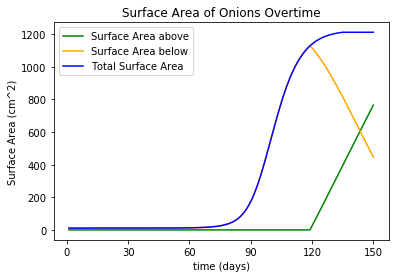

In [49]:
A_aboves = []
A_belows = []
A_totals = []
for i in range(1,growth_period+1):
	A = surface_area_model(i)
	A_aboves.append(A[0])
	A_belows.append(A[1])
	A_totals.append(A[0] + A[1])

fig, ax = plt.subplots()
ax.plot(range(1,growth_period+1), A_aboves, color='green', label='Surface Area above')
ax.plot(range(1,growth_period+1), A_belows, color='orange', label='Surface Area below')
ax.plot(range(1,growth_period+1), A_totals, color='blue', label='Total Surface Area')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel='time (days)', ylabel='Surface Area (cm^2)',
       title='Surface Area of Onions Overtime')

plt.xticks(np.arange(0,151,30))

plt.show()

### Analysis for Probability of Body Infection
Five simulations were done to analyze the pb value overtime. An aggregated version (mean) of the values can be seen in the next plot.

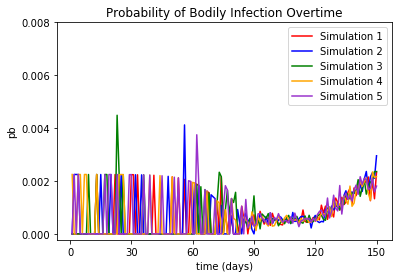

In [43]:
pbs1, pbs2, pbs3, pbs4, pbs5 = [], [], [], [], []
for i in range(1,growth_period+1):
	pbs1.append(pb_model(i)[0])
	pbs2.append(pb_model(i)[0])
	pbs3.append(pb_model(i)[0])
	pbs4.append(pb_model(i)[0])
	pbs5.append(pb_model(i)[0])

fig, ax = plt.subplots()
ax.plot(range(1,growth_period+1), pbs1, color="red", label="Simulation 1")
ax.plot(range(1,growth_period+1), pbs2, color="blue", label="Simulation 2")
ax.plot(range(1,growth_period+1), pbs3, color="green", label="Simulation 3")
ax.plot(range(1,growth_period+1), pbs4, color="orange", label="Simulation 4")
ax.plot(range(1,growth_period+1), pbs5, color="darkorchid", label="Simulation 5")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel='time (days)', ylabel='pb',
       title='Probability of Bodily Infection Overtime')
plt.xticks(np.arange(0,151,30))
plt.yticks(np.arange(0,0.01,0.002))
plt.show()

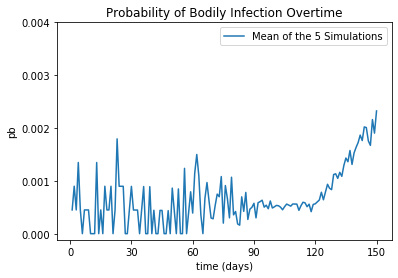

In [44]:
ave_pb = []
for i in range(len(pbs1)):
	llist = [pbs1[i],pbs2[i],pbs3[i],pbs4[i],pbs5[i]]
	ave_pb.append(ave(llist))

fig, ax = plt.subplots()
ax.plot(range(1,growth_period+1), ave_pb, label="Mean of the 5 Simulations")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0)

ax.set(xlabel='time (days)', ylabel='pb',
       title='Probability of Bodily Infection Overtime')
plt.xticks(np.arange(0,151,30))
plt.yticks(np.arange(0,0.005,0.001))
plt.show()